In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
def factor_function(i_neighbours, sigma_j, j_neighbours, permutation):
    """
    sigma_i: int, spin of the site i
    i_neighbours: list, spin of the neighbours of site i, size d-1
    sigma_j: int, spin of the site j
    j_neighbours: list, spin of the neighbours of site j, size d-1

    """
    final = 1
    total = 0
    

    total = sigma_j + np.sum(j_neighbours) + np.sum(i_neighbours) + np.sum(permutation)
    
    if total == 0:
        final *= 1
    else:
        return 0
    
    return final



In [3]:
def multiply_messages(i, i_neighbours, j, perm, d, psi):
    mult = 1
    for k in range(d-1):
        index = (i_neighbours[k],) + tuple(perm[k*(d-1):(k+1)*(d-1)]) + (i,) + (j,) + tuple(i_neighbours[:k]) + tuple(i_neighbours[k+1:])
        mult *= psi[index]
    return mult
        

In [4]:
##Symmetries for Efficiency

def generate_indices(d):
    index_1 = (1, ) + tuple([0, ]*(2*d-1)) 
    index_2 = (0, 1) + tuple([0, ]*(2*d-2))
    index_3 = tuple([0, ]*(2*d))
    indices_permutations = [(index_1), (index_2), (index_3)] 
    return indices_permutations

def generate_indices_update(d):
    indices_2_tuples = list(tuple(itertools.product([0,1], repeat=d-1)))
    indices_2 = []
    for i in range(d-1):
        indices_begin = (0, )*(i+1) + (1, ) + (0,)*(d-i-1) 
        indices_2.extend([(indices_begin + permutation) for permutation in indices_2_tuples])

    indices_3_tuples = list(tuple(itertools.product([0,1], repeat=d)))
    begin_tuple = tuple([0, ]*(d)) 
    indices_3 = [(begin_tuple + permutation) for permutation in indices_3_tuples]

    return indices_2, indices_3
    
 
def update_psi_symmetries(psi, indices_2, indices_3, indices_permutations):
    for indices in indices_2:
        psi[indices] = psi[indices_permutations[1]]

    for indices in indices_3:
        psi[indices] = psi[indices_permutations[2]]

def initial_symmetries_update_psi(psi, d):
    indices_0_tuples = list(tuple(itertools.product([0,1], repeat=2*d-1)))[1:]
    indices_0 = [((1, ) + permutation) for permutation in indices_0_tuples]

    indices_0_more_tuples = list(tuple(itertools.product([0,1], repeat=2*d-1)))
    indices_0_more = [((0, ) + permutation) for permutation in indices_0_more_tuples]


    indices_2_tuples = list(tuple(itertools.product([0,1], repeat=d-1)))
    indices_2 = []
    for i in range(d-1):
        indices_begin = (0, )*(i+1) + (1, ) + (0,)*(d-i-1) 
        indices_2.extend([(indices_begin + permutation) for permutation in indices_2_tuples])
    
    indices_3_tuples = list(tuple(itertools.product([0,1], repeat=d)))
    begin_tuple = tuple([0, ]*(d)) 
    indices_3 = [(begin_tuple + permutation) for permutation in indices_3_tuples]
    
    indices_3.extend(indices_2)

    indices_0.extend(list(filter(lambda x: x not in indices_3, indices_0_more)))

    for indices in indices_0:
        psi[indices] = 0

In [5]:
import time

In [73]:
def generate_permutations(d):
    final_permutations = []
    valid_permutations = []
    for perm in itertools.product([0, 1], repeat=d-1):
        if sum(perm) <= 1:
            valid_permutations.append(perm)
        
    combinations = [sum(combination, ()) for combination in itertools.product(valid_permutations, repeat=d-1)]
    
    final_permutations.append([(0, )*((d-1)*(d-1))])
    final_permutations.append(combinations)
    final_permutations.append(combinations)
    return final_permutations

def generate_indices_observables(d):
    valid_permutations = []
    for perm in itertools.product([0, 1], repeat=d):
        if sum(perm) <= 1:
            valid_permutations.append(perm)
        
    combinations = [sum(combination, ()) for combination in itertools.product(valid_permutations, repeat=2)]
    return combinations

In [25]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.8, verbose=0, init_psi=None):
    shape = tuple([2] * d + [2] * d)
    psi=np.zeros(shape)
    indices_permutations = generate_indices(d)
    indices_2, indices_3 = generate_indices_update(d)
    if init_psi is None:
        psi=np.random.uniform(size=shape)
        initial_symmetries_update_psi(psi, d)
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=generate_permutations(d)

    # loop_start_time = time.time()
    # permutations_time = 0
    
    for t in range(max_iter):
        psi_new=np.zeros(shape)
        for idx, indices in enumerate(indices_permutations):
            i = indices[0]
            i_neighbours = indices[1:d]
            j = indices[d]
            j_neighbours = indices[d+1:]
            # part_start_time = time.time()
            for perm in permutations[idx]:
                mult = 1
                if i == 1:
                    if factor_function(i_neighbours, j, j_neighbours, perm)==0:
                        continue
                mult = multiply_messages(i, i_neighbours, j, perm, d, psi)
                psi_new[indices] += np.exp(mu*i)*mult
            # part_end_time = time.time()
            # permutations_time += part_end_time - part_start_time
        
        update_psi_symmetries(psi_new, indices_2, indices_3, indices_permutations)
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.ones(shape)/np.prod(shape)
            print("Warning: psi_new is zero !")
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            # loop_time = time.time() - loop_start_time
            # print("loop time: ", loop_time)
            # print("permutations time: ", permutations_time/loop_time*100, "%")
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [80]:
test_messages = BP(7, mu=6, tol=1e-12, max_iter=300, damping_parameter=0.6, verbose=0)

KeyboardInterrupt: 

In [34]:
print(np.round(test_messages,3))

[[[[[[[[0.021 0.021]
       [0.021 0.021]]

      [[0.021 0.021]
       [0.021 0.021]]]


     [[[0.021 0.021]
       [0.021 0.021]]

      [[0.021 0.021]
       [0.021 0.021]]]]



    [[[[0.023 0.023]
       [0.023 0.023]]

      [[0.023 0.023]
       [0.023 0.023]]]


     [[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   ]]]]]




   [[[[[0.023 0.023]
       [0.023 0.023]]

      [[0.023 0.023]
       [0.023 0.023]]]


     [[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   ]]]]



    [[[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   ]]]


     [[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   ]]]]]]





  [[[[[[0.023 0.023]
       [0.023 0.023]]

      [[0.023 0.023]
       [0.023 0.023]]]


     [[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   ]]]]



    [[[[0.    0.   ]
       [0.    0.   ]]

      [[0.    0.   ]
       [0.    0.   

In [67]:
def update_observables(psi, mu, d=3):
        phi_=0
        phi__=0

        permutations=generate_permutations(d)[1]
        indices_permutations = list(generate_indices_observables(d))
        
        numerator=0
        
        for indices in indices_permutations:
            i = indices[0]
            i_neighbours = indices[1:d]
            j = indices[d]
            j_neighbours = indices[d+1:]
            for perm in permutations:
                mult=1
                if i==1:
                    if factor_function(i_neighbours, j, j_neighbours, perm)==0:
                        continue
                mult=multiply_messages(i, i_neighbours, j, perm, d, psi)
                last_message_idx = (j,) + tuple(j_neighbours) + (i,) + tuple(i_neighbours)
                mult*=psi[last_message_idx]
                phi_+=np.exp(mu*i)*mult
                numerator+=i*mult*np.exp(mu*i)
                
            entropy_idx_left = (i,) + tuple(i_neighbours) + (j,) + tuple(j_neighbours)
            entropy_idx_right = (j,) + tuple(j_neighbours) + (i,) + tuple(i_neighbours)
            phi__+=psi[entropy_idx_left]*psi[entropy_idx_right]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

In [52]:
def update_observables_diagnostic(psi, mu, d=3):
        dictionary_updates = {}
        phi_=0
        phi__=0

        permutations=generate_permutations(d)[1]
        indices_permutations = list(itertools.product([0,1], repeat=d*2))
        
        numerator=0
        
        for indices in indices_permutations:
            i = indices[0]
            i_neighbours = indices[1:d]
            j = indices[d]
            j_neighbours = indices[d+1:]
            perm_phi = 0
            for perm in permutations:
                mult=1
                if i==1:
                    if factor_function(i_neighbours, j, j_neighbours, perm)==0:
                        continue
                mult=multiply_messages(i, i_neighbours, j, perm, d, psi)
                last_message_idx = (j,) + tuple(j_neighbours) + (i,) + tuple(i_neighbours)
                mult*=psi[last_message_idx]
                perm_phi+=np.exp(mu*i)*mult
                numerator+=i*mult*np.exp(mu*i)
            phi_+=perm_phi
                
            entropy_idx_left = (i,) + tuple(i_neighbours) + (j,) + tuple(j_neighbours)
            entropy_idx_right = (j,) + tuple(j_neighbours) + (i,) + tuple(i_neighbours)
            perm_phi__=psi[entropy_idx_left]*psi[entropy_idx_right]
            phi__+=perm_phi__
            dictionary_updates[indices] = (perm_phi, perm_phi__)

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s, dictionary_updates

In [75]:
mu_space = np.linspace(0, 10, 100)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in tqdm(mu_space):
    psi = BP(d, mu=mu, verbose=0, max_iter=500, tol=1e-12, damping_parameter=0.7, init_psi=None)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

100%|██████████| 100/100 [00:00<00:00, 226.85it/s]


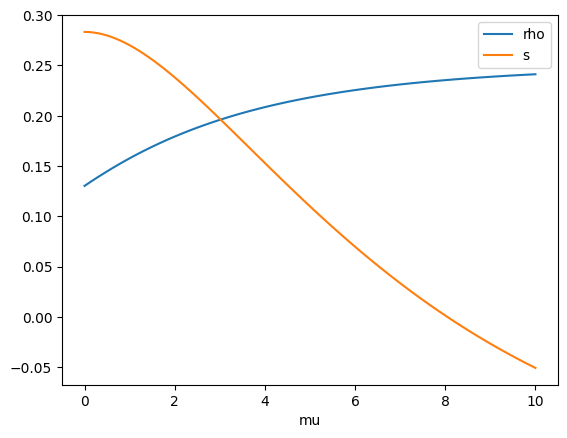

In [76]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()

In [20]:
def find_zero_bisection(arr):
    # Function to find zero using bisection method
    left = 0
    right = len(arr) - 1
    if(arr[left]*arr[right] > 0):
        print("No zero crossing found")
        return -1

    while right - left > 1:
        mid = (left + right) // 2
        if arr[mid] == 0:
            return mid  # Zero found at index 'mid'
        elif arr[mid] * arr[left] < 0:
            right = mid
        else:
            left = mid

    # If exact zero not found, return the index closest to zero
    return left if abs(arr[left]) < abs(arr[right]) else right

In [77]:
def complete_run(d, mu_space, verbose=0, max_iter=10000, damping_parameter=0.8):
    phi_list = []
    rho_list = []
    s_list = []
    for mu in mu_space:
        psi = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        phi, rho, s = update_observables(psi, mu, d)
        phi_list.append(phi)
        rho_list.append(rho)
        s_list.append(s)

    zero_index = find_zero_bisection(s_list)
    if zero_index == -1:
        return -1
    return rho_list[zero_index]

In [12]:
find_zero_bisection(s_list)
print(rho_list[find_zero_bisection(s_list)])

No zero crossing found
No zero crossing found
0.09862185251373098


In [78]:
# d_list = [4, 5, 6, 7]
d_list = [3,4,5,6]
densest_packings = {}
mu_space = np.linspace(3, 9, 100)
for d in tqdm(d_list):
    densest_packings[d] = complete_run(d, mu_space, max_iter=10000, damping_parameter=0.7)
    print("Densest packing for d = ", d, " is ", densest_packings[d])

 25%|██▌       | 1/4 [00:00<00:01,  2.26it/s]

Densest packing for d =  3  is  0.23549031862994843


 50%|█████     | 2/4 [00:03<00:03,  1.82s/it]

Densest packing for d =  4  is  0.17566046601246388


 75%|███████▌  | 3/4 [00:42<00:18, 18.82s/it]

Densest packing for d =  5  is  0.13663992626378305


100%|██████████| 4/4 [12:42<00:00, 190.53s/it]

Densest packing for d =  6  is  0.10993254841273546


In [79]:
d_list = [7]
densest_packings = {}
mu_space = np.linspace(3, 9, 100)
for d in tqdm(d_list):
    densest_packings[d] = complete_run(d, mu_space, max_iter=10000, damping_parameter=0.7)
    print("Densest packing for d = ", d, " is ", densest_packings[d])

  0%|          | 0/1 [10:00:34<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(densest_packings)

{3: 0.23548975165587643}


Stability Analysis